In [199]:
import gzip, json, re
from collections import defaultdict, Counter
from os import listdir
import sys
import pylab as plt
import matplotlib.cm as cm
import numpy as np
import random
from datetime import datetime
import statsmodels.api as sm
import time
from copy import deepcopy
from itertools import groupby
import itertools
import networkx as nx
from sklearn import manifold
import gensim
from scipy import spatial
from scipy.stats.stats import pearsonr
import matplotlib as mpl
from sklearn import cluster, covariance, manifold
from sklearn.manifold import TSNE,SpectralEmbedding,MDS,Isomap,LocallyLinearEmbedding
%matplotlib inline

def diff_month(d1, d2):
    return (d1.year - d2.year)*12 + d1.month - d2.month

def flushPrint(www):
    sys.stdout.write('\r')
    sys.stdout.write('%s' % www)
    sys.stdout.flush()

def add_subplot_axes(ax,rect,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height],axisbg=axisbg)
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax


### 1. Data preparation

In [2]:
# contribution data
W=defaultdict(lambda:defaultdict(lambda:0))#n of contributions
#X=defaultdict(lambda:defaultdict(lambda:0))#last contributing time
#N={}
n=0
with open('/Users/lingfeiw/Documents/bigdata/Github_Small/PushEvent.csv', "rb") as f:
    for line in f:
        n+=1
        if n%1000000==0:
            flushPrint(n/1000000)#138
        line= line.strip().split(',')
        if len(line)==3:
            actor,repo,date=line
        if len(line)==5:
            actor,repo,date,pushSize,realSize=line
        actor=int(actor)
        repo=int(repo)
        date=date[:10]
        W[repo][actor]+=1
        #if date>X[repo][actor]:
            #X[repo][actor]=date

138

In [4]:
# identify core contributors
C={}
n=0
for i in W:
    n+=1
    if n%1000000==0:
        flushPrint(n/1000000)
    ms=np.mean(W[i].values())
    C[i]=[k for k,v in W[i].items() if v>=ms]

9

In [5]:
len([i for i in C if len(C[i])>1]),len(C)

(164672, 9932077)

In [370]:
164672/9932077.0

0.016579815077953988

### 2. Team member embedding by co-occurence

In [6]:
# team embedding data
train_teams=[]
n=0
for i in C:
    coreTeam=map(str,C[i])
    if len(C[i])>1:
        new=gensim.models.doc2vec.TaggedDocument(coreTeam, [n])
        train_teams.append(new)
        n+=1
n

164672

In [7]:
teamModel = gensim.models.doc2vec.Doc2Vec(size=50, min_count=2, iter=20, workers=4)
teamModel.build_vocab(train_teams)
%time teamModel.train(train_teams, total_examples=teamModel.corpus_count, epochs=teamModel.iter)

CPU times: user 2min 9s, sys: 1min 8s, total: 3min 18s
Wall time: 2min 29s


7170595

In [8]:
len(teamModel.wv.vocab)

59749

### 3. The (programming lanaguge) skills vectors of users

In [10]:
# project creator 
U={}
with open('/Users/lingfeiw/Documents/bigdata/Github_Small/CreateEvent.csv', "rb") as f:
    for line in f:
        actor,repo,date=line.strip().split(',')
        repo=int(repo)
        U[repo]=actor

# project language
L={}
f = open('/Users/lingfeiw/Documents/bigdata/Github_Small/Repo_final.txt', "rb")
for line in f:
    repoID, repoName, language, teamSize, NofPushes, repoFinalSize = line.strip().split('\t')
    L[int(repoID)]=language

# project popularity
n=0
P=defaultdict(lambda:0)
with open('/Users/lingfeiw/Documents/bigdata/Github_Small/ForkEvent.csv', "rb") as f:
    for line in f:
        n+=1
        if n%1000000==0:
            flushPrint(n/1000000)
        line= line.strip().split(',')
        actor,repo,date=line
        repo=int(repo)
        if repo in U and actor!=U[repo]:#remove self citation
            P[repo]+=1

9

In [13]:
n=0
K=defaultdict(lambda:defaultdict(lambda:[0,0]))# total contributed projects, successful contributed projects, 
for i in C:
    n+=1
    if n%1000000==0:
        flushPrint(n/1000000)
    if i in L and L[i]!='0':
        users=C[i]
        lang=L[i]
        for u in users:
            K[u][lang][0]+=1
        if i in P:#ever cited
            for u in users:
                K[u][lang][1]+=1

9

In [14]:
#top 50 languages for visualization
Z=defaultdict(lambda:0)
for i in K:
    for j in K[i]:
        Z[j]+=1
top50=zip(*sorted(Z.iteritems(), key=lambda (k,v): (-v,k))[:50])[0]
topAll=zip(*sorted(Z.iteritems(), key=lambda (k,v): (-v,k)))[0]

In [15]:
# vectorize those users who at least have one successful project in top 50 languages
Y={}
for u in K:
    if sum(zip(*K[u].values())[1])>0:# at least one successful project in all languages
        vs=[]
        dic=dict(K[u])
        for i in top50:
            if i in dic:
                a,b=dic[i]
                vs.append(b/float(a))
            else:
                vs.append(0)
        if sum(vs)>0:
            Y[u]=vs

### 4. Validating team embedding using skill vectors

In [16]:
v1=Y[378466]
k=16
# userID:[embedding similarity, cos similarity of skill vector, skill vector]
vs=dict((i,[j,1 - spatial.distance.cosine(v1, Y[int(i)]),Y[int(i)]]) for i,j in teamModel.most_similar('378466',topn=k)\
        if int(i) in Y )
rs=[i for i,j in teamModel.most_similar('378466',topn=k) if int(i) in Y]

In [17]:
len(vs),len(rs)

(14, 14)

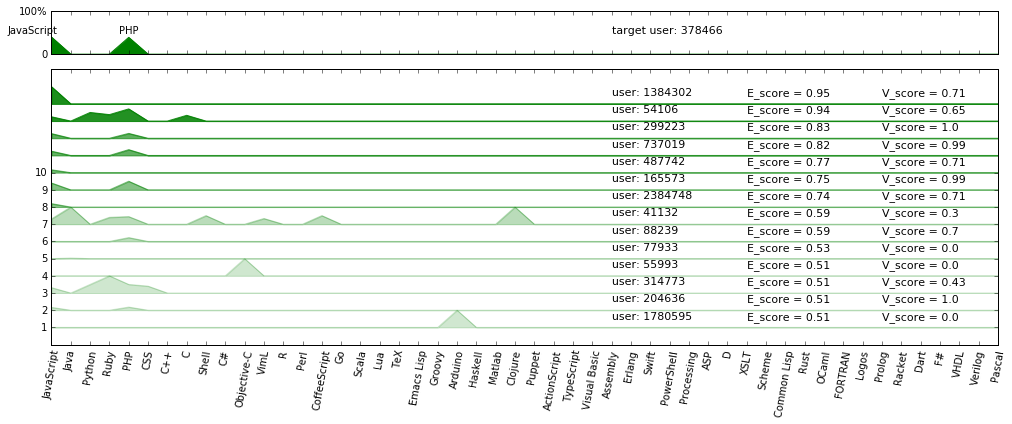

In [18]:
fig = plt.figure(figsize=(14, 6),facecolor='white')
#
ax = plt.subplot2grid(shape=(6,14), loc=(0,0), colspan=14)
n=1
i=378466
plt.plot(range(1,51),np.array(Y[i])+n,color='g',alpha=1)
plt.fill_between(range(1,51),0,np.array(Y[i])+n,color='g',alpha=1)
plt.xlim(1,50)
plt.xticks(range(1,51))
plt.ylim(1,2)
plt.yticks(range(1,3))
#ax.set_xticklabels(top50,rotation=80,fontsize=10)
ax.set_yticklabels(['0','100%'],fontsize=10)
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
plt.text(0,1.5,'JavaScript',ha='center')
plt.text(5,1.5,'PHP',ha='center')
plt.text(30,0.5+n,'target user: '+str(i),size=11)
#
ax = plt.subplot2grid(shape=(6,14), loc=(1,0), rowspan=5,colspan=14)
n=0
for i in rs[::-1]:
    Escore,Vscore, v=vs[i]
    n+=1
    plt.plot(range(1,51),np.array(v)+n,color='g',alpha=Escore**2.5)
    plt.fill_between(range(1,51),n,np.array(v)+n,color='g',alpha=Escore**2.5)
    plt.text(30,0.5+n,'user: '+str(i),size=11)
    plt.text(37,0.5+n,'E_score = '+str(np.round(Escore,2)),size=11)
    plt.text(44,0.5+n,'V_score = '+str(np.round(Vscore,2)),size=11)
plt.xlim(1,50)
plt.xticks(range(1,51))
#plt.ylim(1,2)
plt.yticks(range(1,11))
ax.set_xticklabels(top50,rotation=80,fontsize=10)
#ax.set_yticklabels(['0','100%'],fontsize=10)
#
plt.tight_layout()
#plt.show()
#plt.savefig('/Users/lingfeiw/Documents/research/NoCountryOldMan/GitHubPeople2vec2.pdf')
# embedding distance: relevant but more than skill similarity 

In [19]:
E={}# calculate two kinds of distance between pairs
n=0
for user in teamModel.wv.vocab:
    n+=1
    if n%1000==0:
        flushPrint(n/1000)#59
    if int(user) in Y:
        v1=Y[int(user)]
        for j,Escore in teamModel.most_similar(user,topn=100):
            if int(j) in Y: 
                v2=Y[int(j)]
                Vscore=1 - spatial.distance.cosine(v1, v2)
                E[(user,j)]=[Escore, Vscore]

59

In [23]:
len(E)

3228772

In [22]:
x,y=np.array(E.values()).T
n=defaultdict(lambda:[])
for i,j in zip(x,y):
    n[np.round(i,2)].append(j)
x1,y1,z1=np.array(sorted([(k,np.mean(v),np.std(v)) for k,v in n.items()])).T

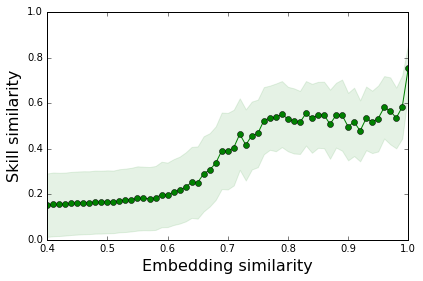

In [24]:
fig = plt.figure(figsize=(6, 4))
#plt.plot(x,y,'b.',alpha=0.1,markersize=1)
plt.plot(x1,y1,'go-')
plt.fill_between(x1,y1-z1/2,y1+z1/2,color='g',alpha=0.1)
plt.xlim(0.4,1)
plt.ylim(0,1)
plt.xlabel('Embedding similarity',size=16)
plt.ylabel('Skill similarity',size=16)
plt.tight_layout()
#plt.savefig('/Users/lingfeiw/Documents/research/NoCountryOldMan/cor.pdf')

### 5. Measuring individual intelligence: individuals success across languages

In [28]:
dd=np.array(Y.values()).T
rm=np.zeros((len(dd),len(dd)))
for i in range(len(dd)):
    for j in range(len(dd)):
        if j>i:
            r,p=pearsonr(dd[i],dd[j])
            if p>0.05:
                r=0
            rm[i,j]=r
            rm[j,i]=r

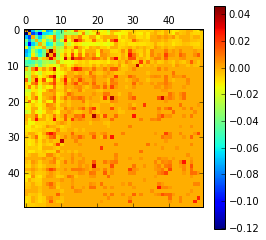

In [31]:
# correlation matrix between 50 skills 
plt.matshow(rm)
plt.colorbar()
plt.show()

In [105]:
coords = SpectralEmbedding(n_components=2,affinity='precomputed').fit_transform(1.0-rm)
pos=dict(zip(top50,coords))

(-4, 5)

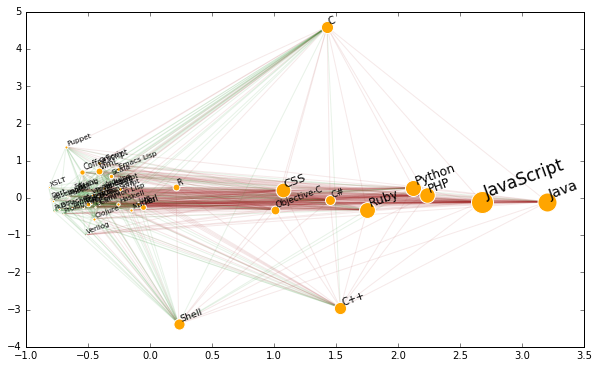

In [144]:
fig = plt.figure(figsize=(10, 6))
for i in pos:
    x,y=pos[i]
    plt.scatter(x,y,s=Z[i]/1000.0,facecolor='Orange',alpha=1,edgecolor='white',zorder=2)
    plt.text(x,y,i,color='k',size=Z[i]/50000.0+7,rotation=20,ha='left',va='bottom')
for i in range(len(dd)):
    for j in range(len(dd)):
        if j>i and rm[i,j]!=0:
            w=rm[i,j]
            xi,yi=pos[top50[i]]
            xj,yj=pos[top50[j]]
            if w>0:
                plt.plot([xi,xj],[yi,yj],color='ForestGreen',alpha=0.1,zorder=1)
            else:
                plt.plot([xi,xj],[yi,yj],color='brown',alpha=0.1,zorder=1)
plt.xlim(-1,3.5)
plt.ylim(-4,5)
# colusion: two kinds of languages: independent skills (that get you a job) and complementary skills

### 6. Measuring group intelligence 

In [210]:
V={}
for u in teamModel.wv.vocab:
    V[int(u)]=teamModel[u]

In [212]:
len(V)

59749

In [213]:
T=defaultdict(lambda:[])
for i in C:
    m=[j for j in C[i] if j in V]
    if len(m)==len(C[i]) and len(m)>1:
        T[tuple(sorted(m))].append(i)

In [235]:
KT=defaultdict(lambda:defaultdict(lambda:[0,0]))# total contributed projects, successful contributed projects, 
for t in T:
    v=T[t]
    for j in v:
        if L[j]!='0':
            lan=L[j]
            KT[t][lan][0]+=1
            if j in P:
                KT[t][lan][1]+=1
            

In [238]:
# vectorize those users who at least have one successful project in top 50 languages
YT={}
for u in KT:
    if sum(zip(*KT[u].values())[1])>0:# at least one successful project in all languages
        vs=[]
        dic=dict(KT[u])
        for i in top50:
            if i in dic:
                a,b=dic[i]
                vs.append(b/float(a))
            else:
                vs.append(0)
        if sum(vs)>0:
            YT[u]=vs

In [239]:
dd=np.array(YT.values()).T
rm=np.zeros((len(dd),len(dd)))
for i in range(len(dd)):
    for j in range(len(dd)):
        if j>i:
            r,p=pearsonr(dd[i],dd[j])
            if p>0.05:
                r=0
            rm[i,j]=r
            rm[j,i]=r

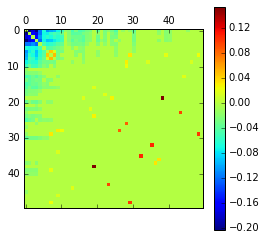

In [240]:
# correlation matrix between 50 skills 
plt.matshow(rm)
plt.colorbar()
plt.show()

In [243]:
coords = SpectralEmbedding(n_components=2,affinity='precomputed').fit_transform(1.0-rm)
pos=dict(zip(top50,coords))

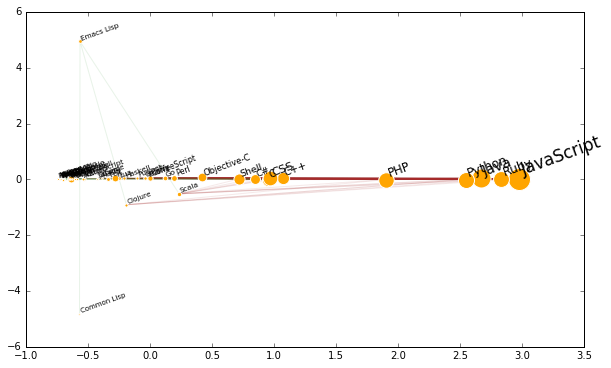

In [244]:
fig = plt.figure(figsize=(10, 6))
for i in pos:
    x,y=pos[i]
    plt.scatter(x,y,s=Z[i]/1000.0,facecolor='Orange',alpha=1,edgecolor='white',zorder=2)
    plt.text(x,y,i,color='k',size=Z[i]/50000.0+7,rotation=20,ha='left',va='bottom')
for i in range(len(dd)):
    for j in range(len(dd)):
        if j>i and rm[i,j]!=0:
            w=rm[i,j]
            xi,yi=pos[top50[i]]
            xj,yj=pos[top50[j]]
            if w>0:
                plt.plot([xi,xj],[yi,yj],color='ForestGreen',alpha=0.1,zorder=1)
            else:
                plt.plot([xi,xj],[yi,yj],color='brown',alpha=0.1,zorder=1)
#plt.xlim(-1,3.5)
#plt.ylim(-4,5)
# colusion: two kinds of languages: independent skills (that get you a job) and complementary skills

### 7. Predicting the performance of two-(core)-members teams

In [145]:
# take all cited, two-member teams 
C2={}
for i in C:
    if len(C[i])==2 and i in P:
        C2[i]=C[i]

In [146]:
len(C2)

47345

In [173]:
# project vector
E2={}
for i in C2:
    a,b=C2[i]
    if str(a) in teamModel.wv.vocab and str(b) in teamModel.wv.vocab:
        E2[i]=np.array([teamModel[str(a)],teamModel[str(b)]]).T
#project label
Y2={}
for i in E2:
    if P[i]>=3:
        Y2[i]=1#success
    else:
        Y2[i]=0# fail

In [175]:
len(E2),len(Y2)

(20462, 20462)

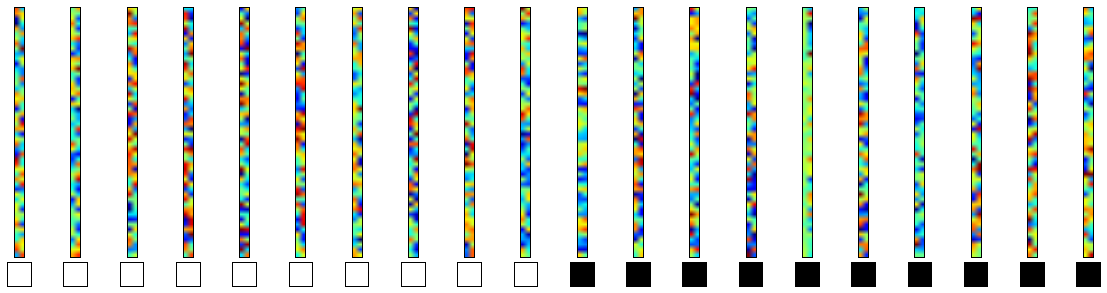

In [189]:
fig = plt.figure(figsize=(20, 5))
s=[3826437,819207,7733259,13697036,8388628,7405589,7077911,6520856,6389785,
 8995277,7307267,9043981,5603342,5505039,22,1474589,32,10117547,983088,458801]
for i in range(40):
    if i <20:
        axi = plt.subplot2grid((10, 20), (0, i),rowspan=9)
        axi.imshow(E2[s[i]])
        axi.set(xticks=[],yticks=[])
    else:
        axi = plt.subplot2grid((10, 20), (9, i-20),rowspan=1)
        axi.imshow([[Y2[s[i-20]]]],vmax=1,vmin=0,cmap='binary')
        axi.set(xticks=[],yticks=[])

In [190]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [205]:
# prameters
N, H, D_in, D_out = 1000, 50, 50*2, 2 # batch size, hidden, input, output dimension
k=0.9# the fraction traning data
L=len(Y2)
l=int(L*k)
Nbatch=500

# initialize
dtype = torch.FloatTensor
w1 = Variable(torch.randn(D_in, H).type(dtype)/float(H), requires_grad=True)
w2 = Variable(torch.randn(H, D_out).type(dtype)/float(H), requires_grad=True)
learning_rate = 1e-6
Loss=defaultdict(lambda:[])

In [206]:
Batches={}
for j in range(Nbatch):
    index=random.sample(Y2.keys()[:l],N)#randomly sample N data points
    y = np.zeros((N, D_out))
    y[np.arange(N), [Y2[i] for i in index]] = 1
    x=[]
    for i in index:
        x.append(E2[i].T.flatten())
    x=np.array(x)
    Batches[j]=[x,y]

In [207]:
# train
for j in Batches:
    flushPrint(j)
    x,y=Batches[j]
    x = Variable(torch.from_numpy(x).type(dtype), requires_grad=False)  
    y = Variable(torch.from_numpy(y).type(dtype), requires_grad=False)
    for t in range(500):
        y_pred = x.mm(w1).clamp(min=0).mm(w2)
        softmax = nn.Softmax()
        y_soft=softmax(y_pred)
        loss = (y_soft - y).pow(2).sum()
        Loss[j].append([t,loss.data[0]])
        loss.backward()
        w1.data -= learning_rate * w1.grad.data
        w2.data -= learning_rate * w2.grad.data
        w1.grad.data.zero_()
        w2.grad.data.zero_()

0

/Users/lingfeiw/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


499

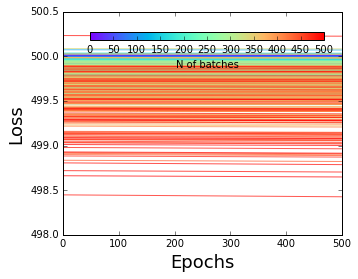

In [208]:
# Dispaly loss decreasing
fig = plt.figure(figsize=(5, 4))
cmap = cm.get_cmap('rainbow',Nbatch)
for i in Loss:
    epochs,loss=zip(*sorted(Loss[i]))
    plt.plot(epochs,loss,color=cmap(i),alpha=0.7)
plt.xlabel('Epochs',fontsize=18)
plt.ylabel('Loss',fontsize=18)
ax1 = fig.add_axes([0.2, 0.8, 0.65, 0.03])
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=mpl.colors.Normalize(vmin=0, vmax=Nbatch),
                                orientation='horizontal')
cb1.set_label('N of batches')

In [209]:
index=Y2.keys()[l:len(E2)]
TestData=[]
for i in index:
    TestData.append(E2[i].T.flatten())
TestData=np.array(TestData)
xTest = Variable(torch.from_numpy(TestData).type(dtype), requires_grad=False)
PredictData = xTest.mm(w1).clamp(min=0).mm(w2)
compare=np.argmax(PredictData.data.numpy(),axis=1)-np.array([Y2[i] for i in index])
Accuracy=list(compare).count(0)/float(len(compare))
Accuracy

0.5266243282852956